In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/saikatgh141/traffic/new_pic2.jpg
/kaggle/input/models/saikatgh141/yolov11n/pytorch/default/1/best.pt


In [2]:
# Install Depth Pro
!git clone https://github.com/apple/ml-depth-pro
%cd ml-depth-pro
!pip install -e .
!source get_pretrained_models.sh

Cloning into 'ml-depth-pro'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 48 (delta 9), reused 2 (delta 2), pack-reused 21 (from 1)
Receiving objects: 100% (48/48), 2.50 MiB | 7.08 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/kaggle/working/ml-depth-pro
Obtaining file:///kaggle/working/ml-depth-pro
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 73.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 94.8 MB/s eta 0:00:00ta 0:00:01
  Building editable for depth_pro (pyproject.toml) ... done
  Created wheel for depth_pro: filename=depth_pro-0.1-0.

In [3]:
# Install YOLOv11 dependencies
!pip install ultralytics opencv-python pillow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 91.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.31.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
depth-pro 0.1 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dopamine-rl 4.1.2 requires gym<=0.25.2, but 

In [4]:
# Libraries
from PIL import Image
import numpy as np
from src import depth_pro
import matplotlib.pyplot as plt
import torch
import cv2
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Load Depth Pro model
depth_model, transform = depth_pro.create_model_and_transforms()
depth_model.eval()

DepthPro(
  (encoder): DepthProEncoder(
    (patch_encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp)

In [6]:
# Load image
image_path = "/kaggle/input/datasets/saikatgh141/traffic/new_pic2.jpg"
image = Image.open(image_path).convert("RGB")
np_image = np.array(image)

In [7]:
# Preprocess and predict depth
image_tensor, _, f_px = depth_pro.load_rgb(image_path)
image_tensor = transform(image_tensor)
prediction = depth_model.infer(image_tensor, f_px=f_px)
depth_map = prediction["depth"].detach().cpu().numpy().squeeze().astype(np.float16)

In [15]:
# Load YOLOv11n segmentation model
model = YOLO("/kaggle/input/models/saikatgh141/yolov11n/pytorch/default/1/best.pt")

In [18]:
# Inference
results = model(image_path)[0]

# Extract Bounding Box data
# Format: [x1, y1, x2, y2, confidence, class_id]
boxes = results.boxes.data.cpu().numpy()

for box in boxes:
    x1, y1, x2, y2, conf, cls = box
    name = results.names[int(cls)]
    print(f"Detected {name} with {conf:.2f} confidence at [{x1}, {y1}, {x2}, {y2}]")


image 1/1 /kaggle/input/datasets/saikatgh141/traffic/new_pic2.jpg: 640x416 19 cars, 1 truck, 9.1ms
Speed: 2.6ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)
Detected car with 0.95 confidence at [262.02191162109375, 1093.029052734375, 474.18524169921875, 1291.949462890625]
Detected car with 0.94 confidence at [77.15385437011719, 777.8679809570312, 216.63243103027344, 897.1393432617188]
Detected car with 0.94 confidence at [594.190185546875, 990.1549682617188, 803.3646850585938, 1173.00537109375]
Detected car with 0.94 confidence at [0.0, 927.9530639648438, 145.0716094970703, 1084.504150390625]
Detected car with 0.92 confidence at [645.296630859375, 1181.6934814453125, 865.0952758789062, 1302.9442138671875]
Detected car with 0.92 confidence at [328.6484069824219, 787.4578247070312, 470.24871826171875, 894.9329833984375]
Detected car with 0.92 confidence at [272.2397766113281, 889.1334838867188, 455.40264892578125, 1066.03466796875]
Detected car with

In [21]:
import cv2
import numpy as np

# 1. Load the original image (use the same path as your YOLO inference)
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_np = np.array(image_rgb) # Now original_np is defined!

# 2. Get dimensions
h, w, _ = original_np.shape

# 3. Resize depth map to match the image dimensions
# (Assuming 'depth_map' is already loaded from your depth estimation model)
depth_map_resized = cv2.resize(depth_map, (w, h), interpolation=cv2.INTER_NEAREST)

# 4. Process Detections
results = model(image_path)[0]
boxes = results.boxes.data.cpu().numpy()

for box in boxes:
    x1, y1, x2, y2, conf, cls = map(int, box[:6])
    
    # Crop the corresponding area in the depth map
    obj_depth_roi = depth_map_resized[y1:y2, x1:x2]
    
    # Get the average distance for this specific car/truck
    if obj_depth_roi.size > 0:
        dist = np.median(obj_depth_roi)
        print(f"Detected {results.names[cls]} at distance: {dist:.2f}")


image 1/1 /kaggle/input/datasets/saikatgh141/traffic/new_pic2.jpg: 640x416 19 cars, 1 truck, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)
Detected car at distance: 21.86
Detected car at distance: 42.25
Detected car at distance: 25.95
Detected car at distance: 29.97
Detected car at distance: 21.09
Detected car at distance: 41.09
Detected car at distance: 30.92
Detected car at distance: 55.50
Detected car at distance: 54.97
Detected car at distance: 81.12
Detected car at distance: 106.75
Detected car at distance: 109.06
Detected car at distance: 83.31
Detected car at distance: 60.81
Detected car at distance: 66.19
Detected truck at distance: 81.25
Detected car at distance: 117.75
Detected car at distance: 20.16
Detected car at distance: 96.88
Detected car at distance: 35.50


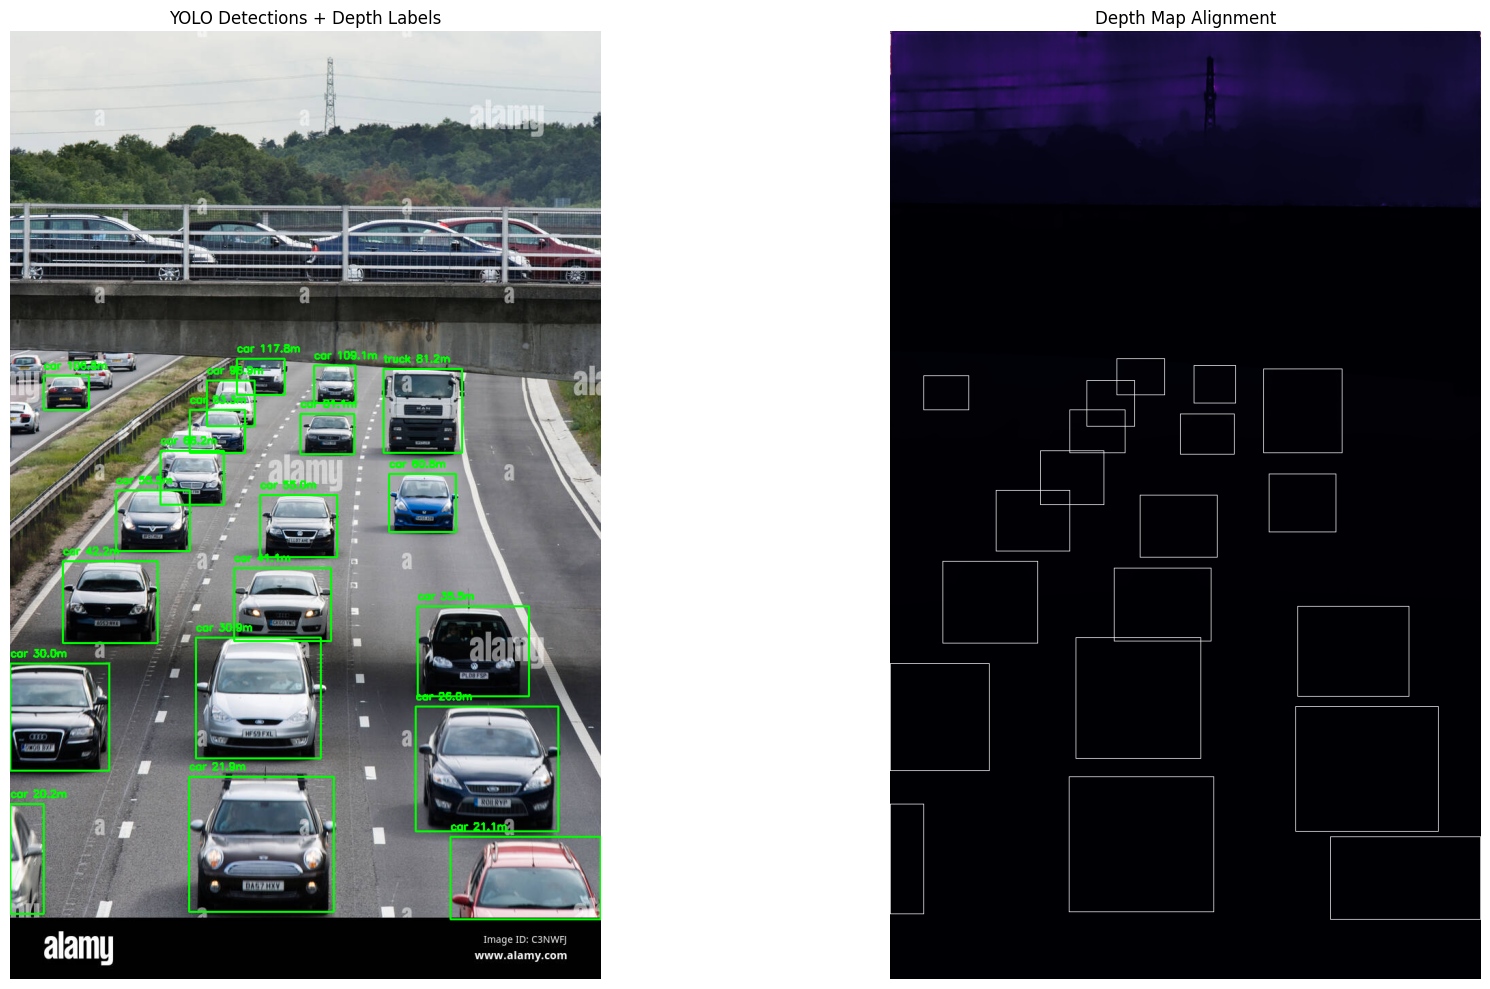

In [22]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 1. Prepare the Depth Map for visualization (Colorize it)
# Normalize to 0-255 and apply a colormap (Magma or Jet)
depth_min, depth_max = depth_map_resized.min(), depth_map_resized.max()
depth_normalized = ((depth_map_resized - depth_min) / (depth_max - depth_min) * 255).astype(np.uint8)
depth_colored = cv2.applyColorMap(depth_normalized, cv2.COLORMAP_MAGMA)

# 2. Prepare the Detection Image
annotated_img = original_np.copy()

# 3. Loop through boxes to annotate both images
for box in results.boxes.data.cpu().numpy():
    x1, y1, x2, y2, conf, cls = map(int, box[:6])
    label = results.names[cls]
    
    # Calculate median depth for this box
    obj_depth = depth_map_resized[y1:y2, x1:x2]
    dist = np.median(obj_depth) if obj_depth.size > 0 else 0
    
    # Draw on Original Image
    cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(annotated_img, f"{label} {dist:.1f}m", (x1, y1 - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Draw on Depth Map (for alignment check)
    cv2.rectangle(depth_colored, (x1, y1), (x2, y2), (255, 255, 255), 1)

# 4. Display Side-by-Side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(annotated_img)
ax[0].set_title("YOLO Detections + Depth Labels")
ax[0].axis('off')

ax[1].imshow(cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB))
ax[1].set_title("Depth Map Alignment")
ax[1].axis('off')

plt.tight_layout()
plt.show()

#***2nd Image***


In [23]:
# Load image
image_path = "/kaggle/input/datasets/saikatgh141/traffic-v3/new_pic3.jpg"
image = Image.open(image_path).convert("RGB")
np_image = np.array(image)

In [24]:
# Preprocess and predict depth
image_tensor, _, f_px = depth_pro.load_rgb(image_path)
image_tensor = transform(image_tensor)
prediction = depth_model.infer(image_tensor, f_px=f_px)
depth_map = prediction["depth"].detach().cpu().numpy().squeeze().astype(np.float16)

In [25]:
# Inference
results = model(image_path)[0]

# Extract Bounding Box data
# Format: [x1, y1, x2, y2, confidence, class_id]
boxes = results.boxes.data.cpu().numpy()

for box in boxes:
    x1, y1, x2, y2, conf, cls = box
    name = results.names[int(cls)]
    print(f"Detected {name} with {conf:.2f} confidence at [{x1}, {y1}, {x2}, {y2}]")


image 1/1 /kaggle/input/datasets/saikatgh141/traffic-v3/new_pic3.jpg: 448x640 14 cars, 3 trucks, 55.0ms
Speed: 2.6ms preprocess, 55.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Detected car with 0.91 confidence at [363.1445617675781, 636.5042114257812, 549.4293212890625, 795.2320556640625]
Detected truck with 0.89 confidence at [1321.048583984375, 575.469970703125, 1499.8985595703125, 993.6795654296875]
Detected car with 0.83 confidence at [870.17138671875, 775.0670166015625, 1181.2210693359375, 991.333740234375]
Detected car with 0.78 confidence at [415.5020751953125, 788.1470336914062, 655.4163818359375, 993.1052856445312]
Detected car with 0.77 confidence at [550.5551147460938, 390.35455322265625, 672.0847778320312, 490.3436279296875]
Detected truck with 0.76 confidence at [1007.7265014648438, 424.0948791503906, 1177.034912109375, 741.0860595703125]
Detected car with 0.74 confidence at [287.2876892089844, 328.0902404785156, 398.031005859375, 415.468017578125

In [27]:
import cv2
import numpy as np

# 1. Load the original image (use the same path as your YOLO inference)
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_np = np.array(image_rgb) # Now original_np is defined!

# 2. Get dimensions
h, w, _ = original_np.shape

# 3. Resize depth map to match the image dimensions
# (Assuming 'depth_map' is already loaded from your depth estimation model)
depth_map_resized = cv2.resize(depth_map, (w, h), interpolation=cv2.INTER_NEAREST)

# 4. Process Detections
results = model(image_path)[0]
boxes = results.boxes.data.cpu().numpy()

for box in boxes:
    x1, y1, x2, y2, conf, cls = map(int, box[:6])
    
    # Crop the corresponding area in the depth map
    obj_depth_roi = depth_map_resized[y1:y2, x1:x2]
    
    # Get the average distance for this specific car/truck
    if obj_depth_roi.size > 0:
        dist = np.median(obj_depth_roi)
        print(f"Detected {results.names[cls]} at distance: {dist:.2f}")


image 1/1 /kaggle/input/datasets/saikatgh141/traffic-v3/new_pic3.jpg: 448x640 14 cars, 3 trucks, 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Detected car at distance: 20.66
Detected truck at distance: 14.03
Detected car at distance: 14.93
Detected car at distance: 15.77
Detected car at distance: 33.47
Detected truck at distance: 21.03
Detected car at distance: 36.72
Detected car at distance: 45.97
Detected car at distance: 18.23
Detected car at distance: 24.19
Detected car at distance: 22.61
Detected car at distance: 30.08
Detected car at distance: 23.78
Detected car at distance: 33.00
Detected car at distance: 13.22
Detected car at distance: 25.89
Detected truck at distance: 28.95


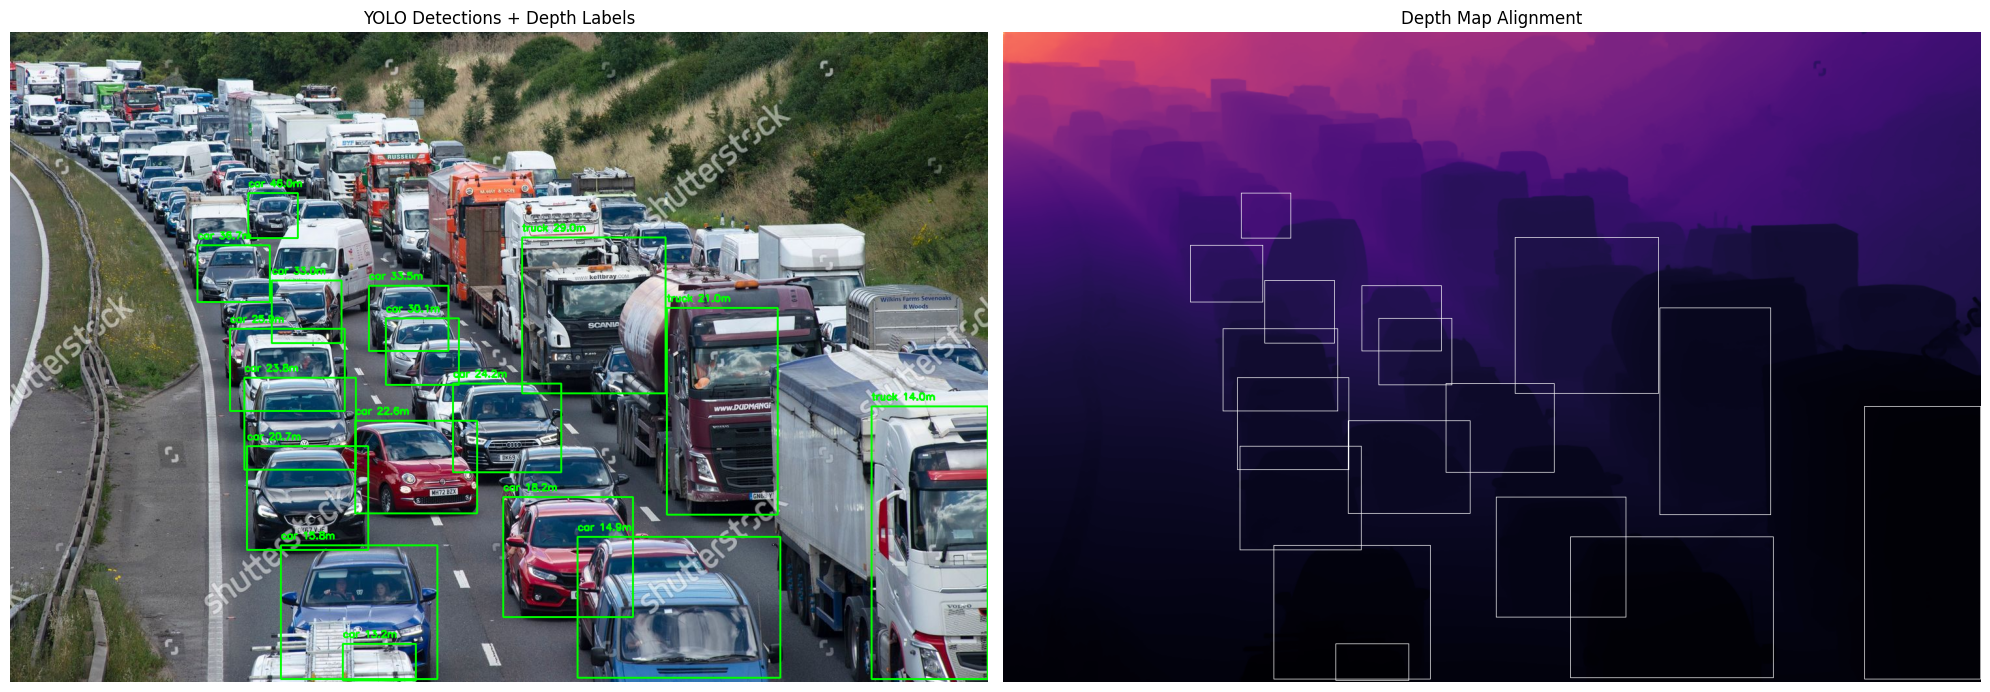

In [28]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 1. Prepare the Depth Map for visualization (Colorize it)
# Normalize to 0-255 and apply a colormap (Magma or Jet)
depth_min, depth_max = depth_map_resized.min(), depth_map_resized.max()
depth_normalized = ((depth_map_resized - depth_min) / (depth_max - depth_min) * 255).astype(np.uint8)
depth_colored = cv2.applyColorMap(depth_normalized, cv2.COLORMAP_MAGMA)

# 2. Prepare the Detection Image
annotated_img = original_np.copy()

# 3. Loop through boxes to annotate both images
for box in results.boxes.data.cpu().numpy():
    x1, y1, x2, y2, conf, cls = map(int, box[:6])
    label = results.names[cls]
    
    # Calculate median depth for this box
    obj_depth = depth_map_resized[y1:y2, x1:x2]
    dist = np.median(obj_depth) if obj_depth.size > 0 else 0
    
    # Draw on Original Image
    cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(annotated_img, f"{label} {dist:.1f}m", (x1, y1 - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Draw on Depth Map (for alignment check)
    cv2.rectangle(depth_colored, (x1, y1), (x2, y2), (255, 255, 255), 1)

# 4. Display Side-by-Side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(annotated_img)
ax[0].set_title("YOLO Detections + Depth Labels")
ax[0].axis('off')

ax[1].imshow(cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB))
ax[1].set_title("Depth Map Alignment")
ax[1].axis('off')

plt.tight_layout()
plt.show()